<a href="https://colab.research.google.com/github/LuiguiUNAB/CIENCIA_DATOS_2025/blob/main/EJERCICIO_DATASET_SELECCIONADO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wquantiles

Dataset cargado: /content/drive/MyDrive/FUNDAMENTOS DE CIENCIA DE DATOS /ncr_ride_bookings.csv — shape: (150000, 22)

Muestra (5 filas):
      Date     Time   Booking ID        Booking Status  Customer ID  Vehicle Type     Pickup Location          Drop Location  Avg VTAT  Avg CTAT  Cancelled Rides by Customer Reason for cancelling by Customer  Cancelled Rides by Driver     Driver Cancellation Reason  Incomplete Rides Incomplete Rides Reason  Booking Value  Ride Distance  Driver Ratings  Customer Rating Payment Method            Datetime
2024-09-26 18:42:26 "CNR1342932" Cancelled by Customer "CID7188245"      Go Sedan           Cyber Hub           Jahangirpuri      11.5       NaN                          1.0                 AC is not working                        NaN                            NaN               NaN                     NaN            NaN            NaN             NaN              NaN            NaN 2024-09-26 18:42:26
2024-03-06 17:19:25 "CNR4750444"   Cancelled by Dri

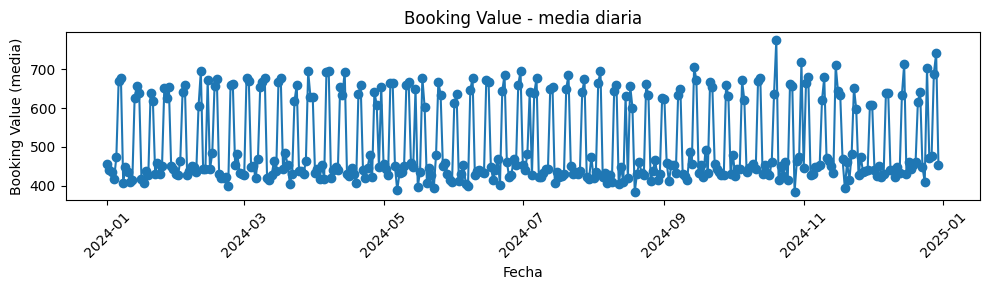

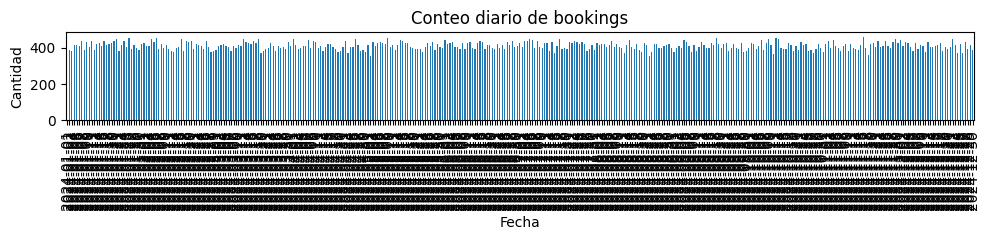

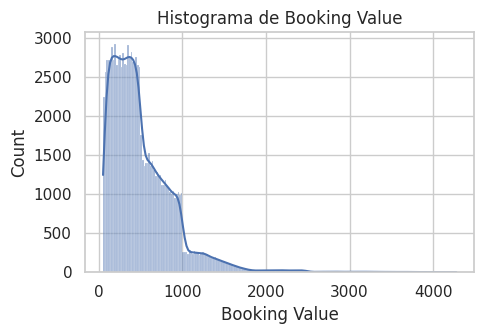

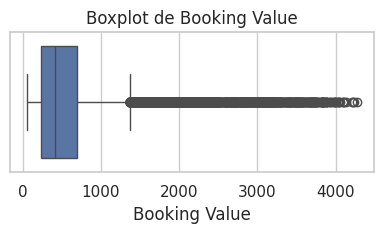

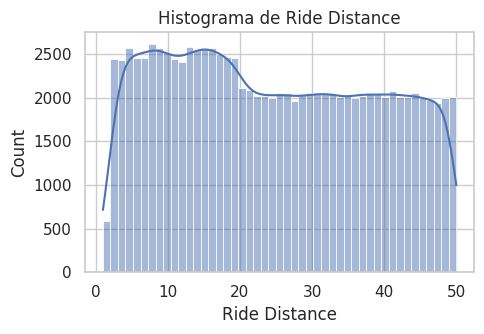

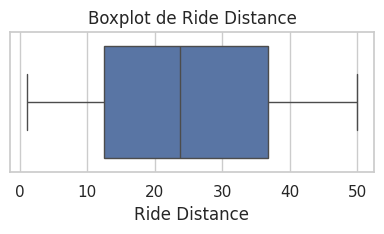

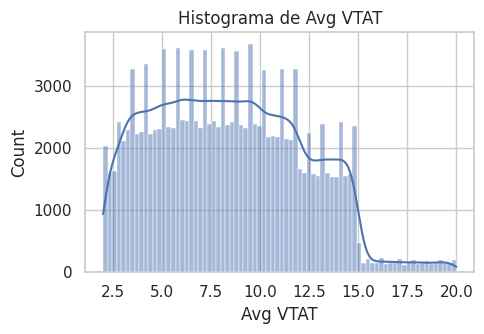

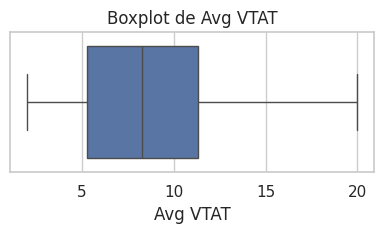

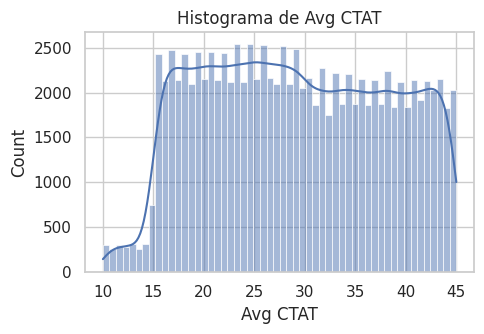

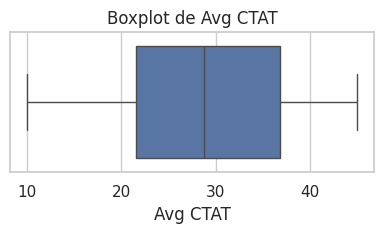

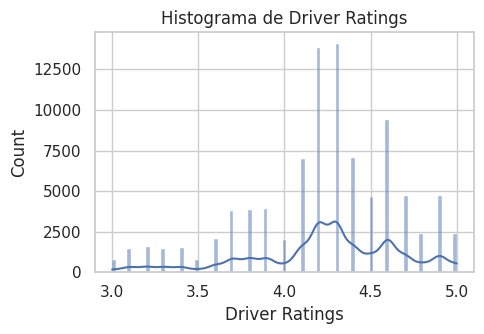

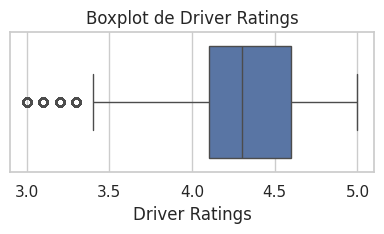

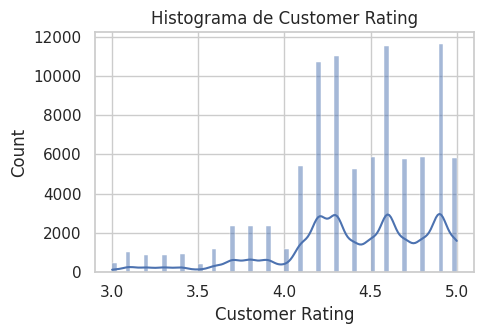

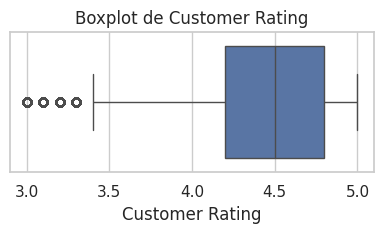

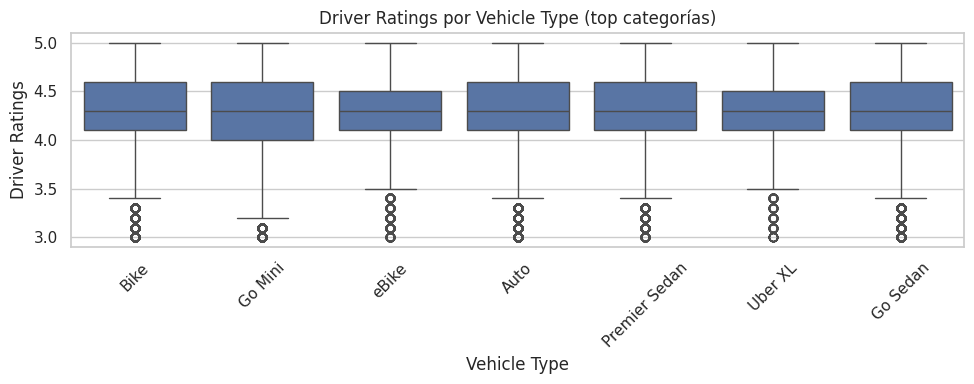


Vista previa final (primeras 10 filas):
      Date     Time   Booking ID      Booking Status  Customer ID Vehicle Type Pickup Location       Drop Location  Avg VTAT  Avg CTAT  Cancelled Rides by Customer Reason for cancelling by Customer  Cancelled Rides by Driver          Driver Cancellation Reason  Incomplete Rides Incomplete Rides Reason  Booking Value  Ride Distance  Driver Ratings  Customer Rating Payment Method            Datetime  Date_only
2024-01-01 00:19:34 "CNR4352144"           Completed "CID8362794"         Bike     Udyog Vihar       Ambience Mall      10.8      38.9                          NaN                               NaN                        NaN                                 NaN               NaN                     NaN           99.0          37.98             4.8              4.8           Cash 2024-01-01 00:19:34 2024-01-01
2024-01-01 01:35:18 "CNR9147645"           Completed "CID8300238"      Go Mini   Basai Dhankot             Madipur       8.5      15.1 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import trim_mean
import wquantiles

PATH = "/content/drive/MyDrive/FUNDAMENTOS DE CIENCIA DE DATOS /ncr_ride_bookings.csv"
df = pd.read_csv(PATH)
df.columns = df.columns.str.strip()  # limpiar espacios en nombres de columnas

# Punto 2: parsear fecha/hora y tipos
# Combinar Date + Time en Datetime si ambas columnas existen
if {"Date", "Time"}.issubset(df.columns):
    df["Datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str), errors="coerce")
else:
    df["Datetime"] = pd.to_datetime(df.get("Date", pd.NaT), errors="coerce")

# Columnas numéricas esperadas; convertir a numérico con coerción
num_cols_expected = [
    "Avg VTAT", "Avg CTAT", "Booking Value", "Ride Distance",
    "Driver Ratings", "Customer Rating",
    "Cancelled Rides by Customer", "Cancelled Rides by Driver", "Incomplete Rides"
]
for c in num_cols_expected:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Punto 3: overview rápido
print(f"Dataset cargado: {PATH} — shape: {df.shape}\n")
print("Muestra (5 filas):")
print(df.sample(5).to_string(index=False))
print("\nColumnas:")
print(df.columns.tolist())
print("\nInfo:")
df.info()
print("\nDescribe (numéricas):")
print(df.describe().T)

# Punto 4: medidas de tendencia central (columnas numéricas relevantes)
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in ("index",)]
print("\nMedidas de tendencia central (columnas numéricas detectadas):")
for c in numeric_cols:
    s = df[c].dropna()
    if s.empty:
        continue
    mean = s.mean()
    median = s.median()
    trimmed = trim_mean(s, 0.1) if len(s) >= 10 else np.nan
    std = s.std()
    mn, mx = s.min(), s.max()
    print(f"\nColumna: {c}")
    print(f"  count: {len(s)}  mean: {mean:.4f}  median: {median:.4f}  trimmed(10%): {trimmed:.4f}  std: {std:.4f}")
    print(f"  min: {mn}  max: {mx}")

# Punto 5: análisis categórico y conteos
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("\nConteos principales de columnas categóricas relevantes:")
for c in ["Booking Status", "Vehicle Type", "Payment Method", "Driver Cancellation Reason", "Reason for cancelling by Customer"]:
    if c in df.columns:
        print(f"\n{c} — top 8:")
        print(df[c].value_counts(dropna=False).head(8).to_string())

# Punto 6: cancelaciones e incompletas
print("\nResumen de cancelaciones / incompletas (si existen):")
for c in ["Cancelled Rides by Customer", "Cancelled Rides by Driver", "Incomplete Rides"]:
    if c in df.columns:
        s = df[c].dropna()
        print(f"  {c}: total={s.sum():.0f}  mean={s.mean():.4f}  non-null={s.count()}")

# Punto 7: ubicaciones más frecuentes
for c in ["Pickup Location", "Drop Location"]:
    if c in df.columns:
        print(f"\nTop 10 {c}:")
        print(df[c].value_counts().head(10).to_string())

# Punto 8: series temporales y agregados por fecha
if "Datetime" in df.columns and df["Datetime"].notna().any():
    df = df.sort_values("Datetime")
    df["Date_only"] = df["Datetime"].dt.date
    # Promedio diario de Booking Value y conteo de bookings
    if "Booking Value" in df.columns:
        daily = df.groupby("Date_only")["Booking Value"].agg(["count", "mean", "median"]).reset_index()
        print("\nSerie diaria — preview:")
        print(daily.head().to_string(index=False))
        plt.figure(figsize=(10,3))
        plt.plot(daily["Date_only"], daily["mean"], marker="o")
        plt.title("Booking Value - media diaria")
        plt.xlabel("Fecha")
        plt.ylabel("Booking Value (media)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    # Conteo diario de bookings
    daily_count = df.groupby("Date_only").size()
    plt.figure(figsize=(10,2.5))
    daily_count.plot(kind="bar")
    plt.title("Conteo diario de bookings")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad")
    plt.tight_layout()
    plt.show()
else:
    print("\nNo se detectaron fechas válidas para análisis temporal.")

# Punto 9: gráficas univariadas (histogramas / boxplots) para variables clave
sns.set(style="whitegrid")
plot_cols = []
for optional in ["Booking Value", "Ride Distance", "Avg VTAT", "Avg CTAT", "Driver Ratings", "Customer Rating"]:
    if optional in df.columns:
        plot_cols.append(optional)

for c in plot_cols:
    plt.figure(figsize=(5,3.5))
    ax = sns.histplot(df[c].dropna(), kde=True)
    ax.set_title(f"Histograma de {c}")
    ax.set_xlabel(c)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(4,2.5))
    sns.boxplot(x=df[c].dropna())
    plt.title(f"Boxplot de {c}")
    plt.tight_layout()
    plt.show()

# Punto 10: comparación de ratings por tipo de vehículo (si hay datos)
if "Vehicle Type" in df.columns and ("Driver Ratings" in df.columns or "Customer Rating" in df.columns):
    rating_col = "Driver Ratings" if "Driver Ratings" in df.columns else "Customer Rating"
    sample = df[[ "Vehicle Type", rating_col]].dropna()
    # limitar categorías si muchas
    top_types = sample["Vehicle Type"].value_counts().nlargest(8).index
    sample = sample[sample["Vehicle Type"].isin(top_types)]
    plt.figure(figsize=(10,4))
    sns.boxplot(data=sample, x="Vehicle Type", y=rating_col)
    plt.title(f"{rating_col} por Vehicle Type (top categorías)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Punto 11: guardar vista previa procesada (opcional)
PRODUCE_OUTPUT = False
if PRODUCE_OUTPUT:
    df.to_csv("/content/ncr_ride_bookings_procesado.csv", index=False)
    print("\nArchivo procesado guardado en /content/ncr_ride_bookings_procesado.csv")

# Punto 12: vista previa final
print("\nVista previa final (primeras 10 filas):")
print(df.head(10).to_string(index=False))
